In [1]:
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(readxl)
library(dplyr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recip

In [2]:
training_data <- read_csv("https://raw.githubusercontent.com/thisisyifulin/group_project-group34-/main/Training_Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.csv") |>
select(STG, SCG, STR, LPR, PEG, UNS)

testing_data <- read_csv("https://raw.githubusercontent.com/thisisyifulin/group_project-group34-/main/Test_Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.csv")

A_grade <- filter(training_data, 1.00 > PEG, PEG > 0.80) |> # changing PEG from decimals to letter grades
mutate(PEG = "A")
B_grade <- filter(training_data, 0.79 > PEG, PEG > 0.65) |> 
mutate(PEG = "B")
C_grade <- filter(training_data, 0.64 > PEG, PEG > 0.55) |> 
mutate(PEG = "C")
D_grade <- filter(training_data, 0.54 > PEG, PEG > 0.50) |> 
mutate(PEG = "D")
F_grade <- filter(training_data, 0.49 > PEG, PEG > 0.00) |> 
mutate(PEG = "F")

mutated_training_data <- bind_rows(A_grade, B_grade, C_grade, D_grade, F_grade)

# repeat w/ test data

A_grade <- filter(testing_data, 1.00 > PEG, PEG > 0.80) |> # changing PEG from decimals to letter grades
mutate(PEG = "A")
B_grade <- filter(testing_data, 0.79 > PEG, PEG > 0.65) |> 
mutate(PEG = "B")
C_grade <- filter(testing_data, 0.64 > PEG, PEG > 0.55) |> 
mutate(PEG = "C")
D_grade <- filter(testing_data, 0.54 > PEG, PEG > 0.50) |> 
mutate(PEG = "D")
F_grade <- filter(testing_data, 0.49 > PEG, PEG > 0.00) |> 
mutate(PEG = "F")

mutated_testing_data <- bind_rows(A_grade, B_grade, C_grade, D_grade, F_grade)

mutated_training_data
mutated_testing_data

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 145 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.08,0.08,0.10,0.24,A,High
0.00,0.00,0.50,0.20,A,High
0.18,0.18,0.55,0.30,A,High
⋮,⋮,⋮,⋮,⋮,⋮
0.72,0.60,0.45,0.79,F,Middle
0.54,0.51,0.55,0.64,F,Low
0.50,0.75,0.81,0.61,F,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.08,0.18,0.63,0.60,A,High
0.20,0.20,0.68,0.67,A,High
0.22,0.22,0.90,0.30,A,High
⋮,⋮,⋮,⋮,⋮,⋮
0.68,0.61,0.34,0.31,F,Low
0.56,0.60,0.77,0.13,F,Low
0.68,0.64,0.79,0.97,F,Middle


In [3]:
#count the amount of each class of PEG
counts_class <- mutated_training_data |>
                group_by(PEG) |>
                summarize(count_class = n())
counts_class

PEG,count_class
<chr>,<int>
A,28
B,38
C,31
D,8
F,125


In [16]:
#finds the mean of predictors

select_training_data <- mutated_training_data |>
select(STG, STR, LPR, PEG) # selecting the variables


predictor_means <- select_training_data |>
                   summarize(across(STG:LPR, mean, na.rm = TRUE))

predictor_means

STG,STR,LPR
<dbl>,<dbl>,<dbl>
0.368813,0.4656304,0.4416522


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.08,0.08,0.10,0.24,A,High
0.00,0.00,0.50,0.20,A,High
0.18,0.18,0.55,0.30,A,High
⋮,⋮,⋮,⋮,⋮,⋮
0.72,0.60,0.45,0.79,F,Middle
0.54,0.51,0.55,0.64,F,Low
0.50,0.75,0.81,0.61,F,Middle


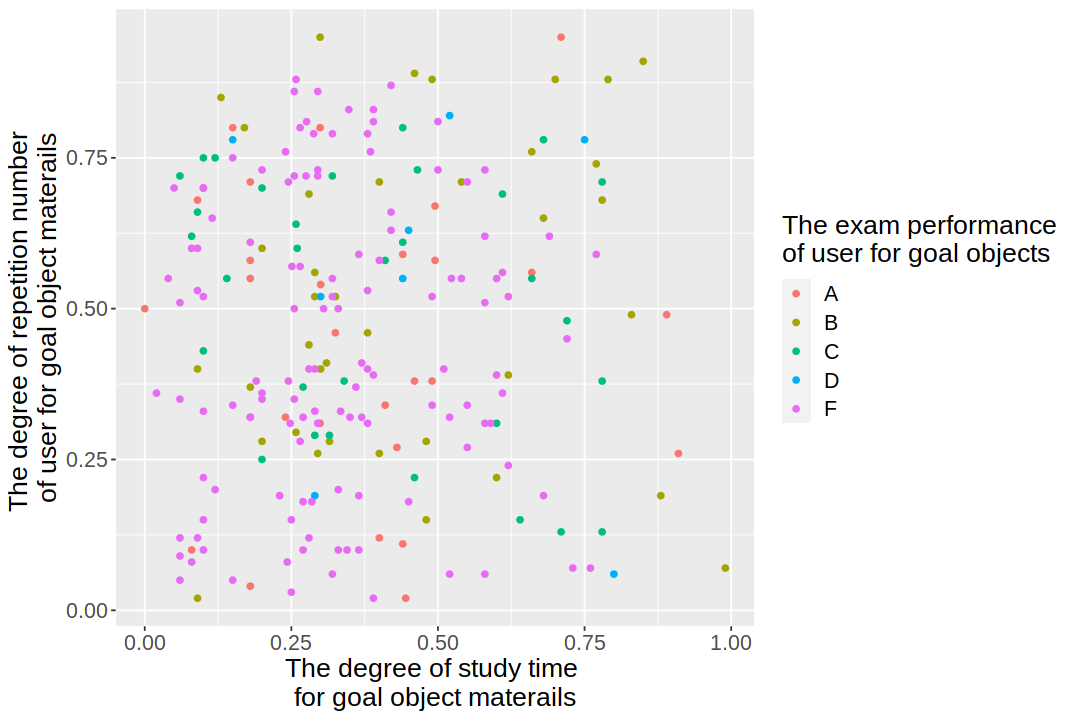

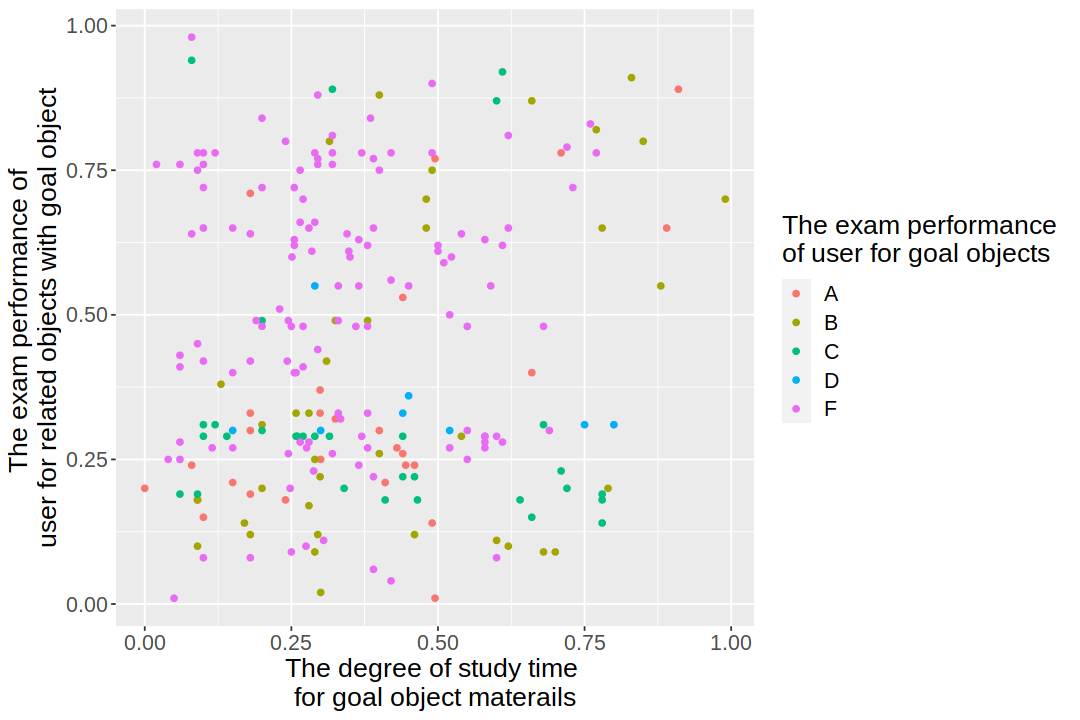

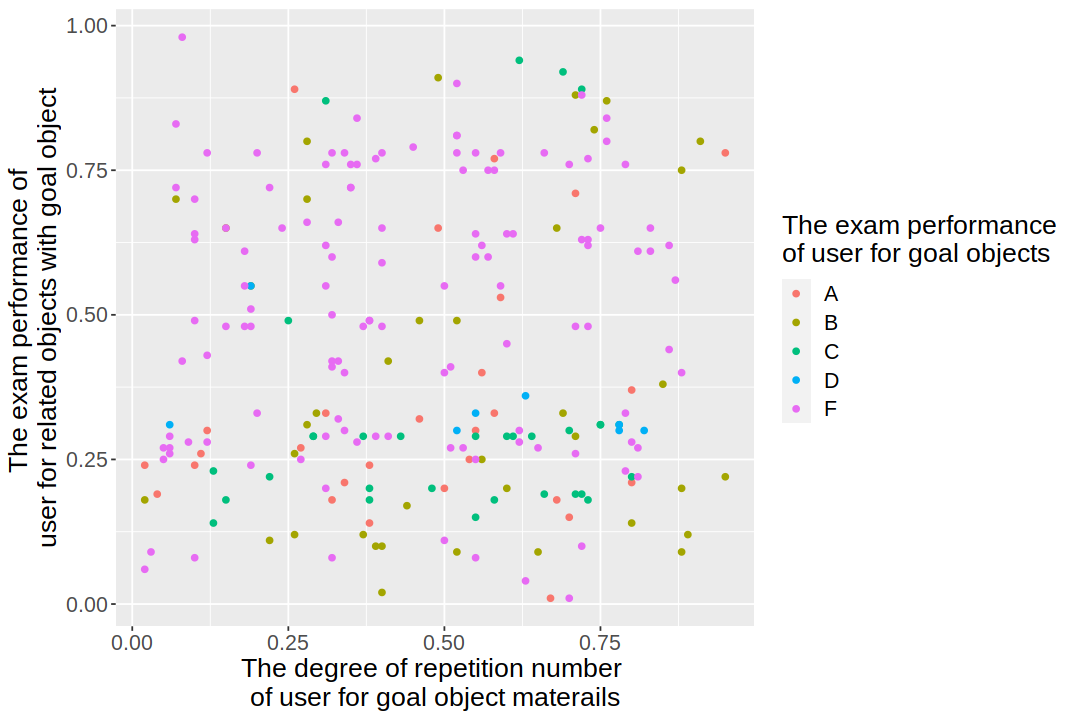

In [32]:

# plot a graph that 

mutated_training_data <- mutated_training_data |>
        mutate(PEG = as_factor(PEG))

mutated_training_data

options(repr.plot.width = 9, repr.plot.height = 6)
stg_str_plot <- mutated_training_data |>
    ggplot(aes(x = STG, 
               y = STR, 
               colour = PEG)) +
        geom_point() +
        labs(x = "The degree of study time \nfor goal object materails",
             y = "The degree of repetition number \nof user for goal object materails",
            colour = "The exam performance \nof user for goal objects") +
        theme(text = element_text(size = 16))
 
stg_lpr_plot <- mutated_training_data |>
    ggplot(aes(x = STG, 
               y = LPR, 
               colour = PEG)) +
        geom_point() +
        labs(x = "The degree of study time \nfor goal object materails",
             y = "The exam performance of \nuser for related objects with goal object",
            colour = "The exam performance \nof user for goal objects") +
        theme(text = element_text(size = 16))
 
str_lpr_plot <- mutated_training_data |>
    ggplot(aes(x = STR, 
               y = LPR, 
               colour = PEG)) +
        geom_point() +
        labs(x = "The degree of repetition number \nof user for goal object materails",
             y = "The exam performance of \nuser for related objects with goal object",
            colour = "The exam performance \nof user for goal objects") +
        theme(text = element_text(size = 16))

stg_str_plot
stg_lpr_plot
str_lpr_plot

                   